# Problem 3: Visualizations and CAM

* <b>Learning Objective:</b> In problem 2, you were asked to use TensorFlow to design and train convolutional neural networks. In this part of the assignment, you are going to play with some fun visualization tricks. We will provide the pretrained models of two well-known CNN architectures: AlexNet and VGG-16 Net to demonstrate visual patterns learned in the filters. In the last part, we introduce Grad-CAM, which visualizes the attended heat map, where the CNN looks at while predicting the labels of the images.

* <b>Provided Codes:</b> We provide the necessary code blocks for each section.
* <b>TODOs:</b> Follow the instructions to complete the TODO parts.

In [55]:
# A bit of setups
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from lib.datasets import *

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Download the Model
Download the vgg16 pretrained model from the [ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy](ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy)  
Download the AlexNet pretrained model from the link [BVLC_ALEXNET](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy)  
And save the two models (.npy files) to `lib/tf_models/`

In [71]:
import numpy as np
from lib.tf_models import vgg16
import os
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Visualizing learned filters [4pt]
In this section we will show you how to visualize the learned convolutional filters.

In [57]:
# Define the vgg network for visualizations
vgg_viz = vgg16.Vgg16()
vgg_viz.load()
vgg_viz.setup()

Model from C:\Users\mohan\Pictures\Assignment1\csci566-assignment1-master\lib\tf_models\vgg16.npy
Pretrained VGG16 successfully loaded!


In [8]:
# Useful function to arrange the images to be shown as a squared grid
def viz_grid(Xs, ubound=255.0, padding=1):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

Model from lib\tf_models\bvlc_alexnet.npy
Pretrained AlexNet successfully loaded!
Model from lib\tf_models\vgg16.npy
Pretrained Vgg-16 successfully loaded!


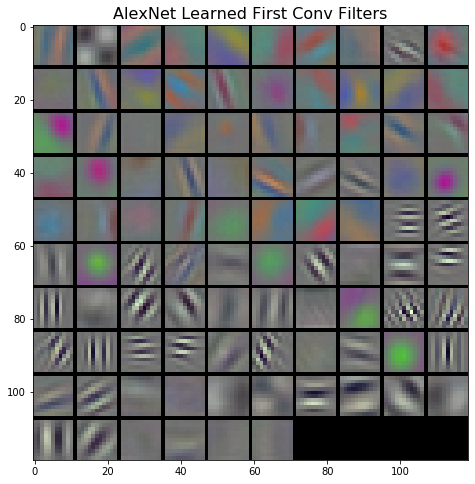

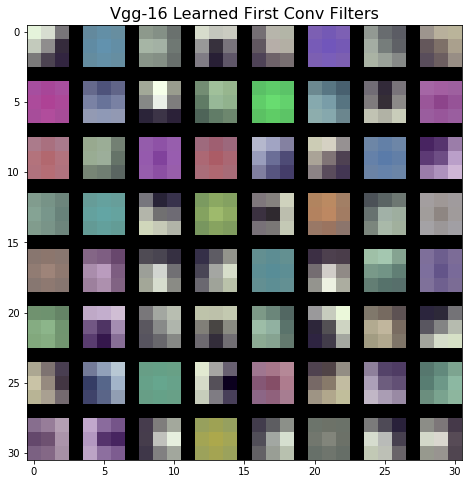

In [59]:
model_paths = {
    "Vgg-16": os.path.join("lib", "tf_models", "vgg16.npy"),
    "AlexNet": os.path.join("lib", "tf_models", "bvlc_alexnet.npy")
}

for net in sorted(model_paths):
    model_path = model_paths[net]
    print("Model from {}".format(model_path))
    pretrained = np.load(model_path, encoding='latin1', allow_pickle=True).item()
    print("Pretrained {} successfully loaded!".format(net))

    first_conv = "conv1_1" if net == "Vgg-16" else "conv1"
    
    conv1 = pretrained[first_conv]
    #############################################################################
    # TODO: Extract the weight and bias from conv1                              #
    # HINT: Examine the data type of conv1?                                     #
    #############################################################################
    w1 = conv1[0]
    b1 = conv1[1]
    
    #############################################################################
    # TODO: Scale the kernel weights, so that they lie in [0,1].                #
    # In order to get the relative information across filters, you should scale #
    # across all the filters, and not individually.                             #
    #############################################################################
    #w_01_min = w1.min(axis=(0, 1), keepdims=True)
    #w_01_max = w1.max(axis=(0, 1), keepdims=True)
    #w_01 = (w1 - w_01_min) / (w_01_max - w_01_min)
    
    w_01 = np.reshape(w1, (np.prod(w1.shape[0:3]), w1.shape[3]))
    w_01 = (w_01 - np.min(w_01))/(np.max(w_01) - np.min(w_01))
    w_01 = np.reshape(w_01, np.shape(w1))
    
    

    #############################################################################
    # TODO: Transpose the scaled kernel weights so that the                     #
    # number of filters comes first in the dimension as (n, H, W, C)            #
    #############################################################################
    Transposed_weight = np.transpose(w_01, [3,0,1,2])
    
    rgb_w = Transposed_weight.tolist()
    rgb_w = np.asarray(rgb_w)

    # Define a figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)
    
    # Grid the rgb_w
    grid = viz_grid(rgb_w)

    ax1.imshow(grid[...,::-1])
    ax1.set_title('{} Learned First Conv Filters'.format(net), fontsize=16)

## Visualizing convolution neural network filters from Problem 2

### Load CIFAR-10 Data

In [10]:
data_train, labels_train, data_test, labels_test = CIFAR10(os.path.join('data', 'cifar-10-batches-py'))

### <font color="Scarlet">Run the following lines of code, and whenever you encounter problems with tf graph, rerun them again<font>

In [ ]:
tf.reset_default_graph()
sess = tf.Session()

### Copy layers from Problem 2
Copy and paste your implementation for all of your layers in problem 2 to below

In [60]:
#############################################################################
# TODO: Define conv2d, max_pool, flatten, fc, norm functions - same as in Problem 2.
# Simply Copy & Paste your code block (with implementation) for layers here
#############################################################################
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.layers.dense(input,units=num_output)

def norm(input):
        return tf.layers.batch_normalization(input)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################


### Copy convolutional neural network from Problem 2 - Base Model
Copy and paste your implementation for the class BaseModel in problem 2 to below:

In [61]:
#############################################################################
# TODO: Define BaseModel - same as in Problem 2.
# Simply Copy & Paste your code block (with implementation) for BaseModel here
# We will load your saved model below.
#############################################################################
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 64
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        #with tf.variable_scope('flatten'):
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        #############################################################################
        # TODO: Adam optimizer 'self.train_op' that minimizes 'self.loss_op'        #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        self.learning_rate = tf.train.exponential_decay(5e-4, global_step, 500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_op)
        

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        #############################################################################
        # TODO: Softmax cross entropy loss 'self.loss_op'                           #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_} 
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: iteration (training step), Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Loss during training')
            plt.xlabel('iteration (training step)')
            plt.ylabel('training loss')
            plt.plot(range(len(losses)), losses, label='loss_training')    
            
        # Graph 2. X: iteration (training step), Y: training accuracy
            plt.subplot(2,1,2)
            plt.title('Accuracy during training')
            plt.ylabel('Accuracy')
            plt.xlabel('iteration (training step)')
            plt.plot(range(len(accuracies)), accuracies, label='training Accuracy')
            plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter


### Copy convolutional neural network from Problem 2 - Your Model
Copy and paste your implementation for the class YourModel in problem 2 to below:

In [62]:
#############################################################################
# TODO: Define YourModel - same as in Problem 2.
# Simply Copy & Paste your code block (with implementation) for YourModel here.
# We will load your saved model below.
#############################################################################
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 15


    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.leaky_relu(self.conv1)
            self.norm1 = norm(self.relu1)           
            print('conv1 layer: ' + str(self.norm1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.norm1, 5, 1, 64)
            self.relu2 = tf.nn.leaky_relu(self.conv2)
            self.norm2 = norm(self.relu2)
            self.pool2 = max_pool(self.norm2, 3, 2)
            print('conv2 layer: ' + str(self.pool2.get_shape()))
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.pool2, 5, 1, 64)
            self.relu3 = tf.nn.leaky_relu(self.conv3)
            self.norm3 = norm(self.relu3)
            print('conv3 layer: ' + str(self.norm3.get_shape()))
        
        with tf.variable_scope('conv4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv4 = conv2d(self.norm3, 3, 1, 128)
            self.relu4 = tf.nn.leaky_relu(self.conv4)
            self.norm4 = norm(self.relu4)
            self.pool4 = max_pool(self.norm4, 3, 2)
            print('conv4 layer: ' + str(self.pool4.get_shape()))
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
        with tf.variable_scope('conv5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv5 = conv2d(self.pool4, 3, 1, 128)
            self.relu5 = tf.nn.leaky_relu(self.conv5)
            self.norm5 = norm(self.relu5)
            print('conv5 layer: ' + str(self.norm5.get_shape()))
        #############################################################################
        with tf.variable_scope('conv6'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv6 = conv2d(self.norm5, 3, 1, 128)
            self.relu6 = tf.nn.leaky_relu(self.conv6)
            self.norm6 = norm(self.relu6)
            self.pool6 = max_pool(self.norm6, 3, 2)
            print('conv6 layer: ' + str(self.pool6.get_shape()))
        
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        with tf.variable_scope('flatten'):
            self.flat = flatten(self.pool6)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc4'):
            self.fc4 = fc(self.flat, 512)
            self.dropout4 = tf.layers.dropout(self.fc4)
            self.relu4 = tf.nn.relu(self.dropout4)
            print('fc4 layer: ' + str(self.relu4.get_shape()))
        
            
        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.relu4, 10)
            print('fc6 layer: ' + str(self.fc6.get_shape()))
            
        # Return the last layer
        return self.fc6

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        #############################################################################
        # TODO: Adam optimizer 'self.train_op' that minimizes 'self.loss_op'        #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        self.learning_rate = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss_op,global_step=global_step)
        
               

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        #############################################################################
        # TODO: Softmax cross entropy loss 'self.loss_op'                           #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        
    

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: iteration (training step), Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Loss during training')
            plt.xlabel('iteration (training step)')
            plt.ylabel('training loss')
            plt.plot(range(len(losses)), losses, label='loss_training')    
            
        # Graph 2. X: iteration (training step), Y: training accuracy
            plt.subplot(2,1,2)
            plt.title('Accuracy during training')
            plt.ylabel('Accuracy')
            plt.xlabel('iteration (training step)')
            plt.plot(range(len(accuracies)), accuracies, label='training Accuracy')
            plt.show()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X : X_, self.Y : Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

### Visualize the learned filters on your trained CIFAR-10 network!
Here we will repeat the above procedure that we did for AlexNet and VGG on your own trained networks, for the first convolutional layer.

In [63]:
def restore_model(saved_file):
    # Restore the model using parameters dict
    variables = tf.global_variables()
    param_dict = {}
    for var in variables:
        var_name = var.name[:-2]
        print('Loading {} from checkpoint. Name: {}'.format(var.name, var_name))
        param_dict[var_name] = var
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join('lib', 'tf_models', 'problem2', saved_file))

In [64]:
# TODO:
def viz_model(model_name):
    with sess.as_default():
        with tf.variable_scope("conv1", reuse=True):
            conv1 = tf.get_variable("w")
            b1    = tf.get_variable("b")
        print (conv1.shape, b1.shape)

        #############################################################################
        # TODO: Extract the weight and bias from conv1                              #
        # For tf models, you should use .eval() function on variables               #
        #############################################################################
        conv1_w = conv1.eval()
        conv1_b1 = conv1.eval()

        #############################################################################
        # TODO: Scale the kernel weights to [0,1]                                   #
        # Hint: Same as you did above                                               #
        #############################################################################
        w_01 = np.reshape(conv1_w, (np.prod(conv1_w.shape[0:3]), conv1_w.shape[3]))
        w_01 = (w_01 - np.min(w_01))/(np.max(w_01) - np.min(w_01))
        w_01 = np.reshape(w_01, np.shape(conv1_w))

        #############################################################################
        # TODO: Transpose the scaled kernel weights so that the                     # 
        # number of filters comes first in the dimension (n, H, W, C)               #
        # Hint: Same as you did above                                               #
        #############################################################################
        Transposed_weight = np.transpose(w_01, [3,0,1,2])
    
        rgb_w = Transposed_weight.tolist()
        rgb_w = np.asarray(rgb_w)

        # Define a figure
        fig = plt.figure(figsize=(8,8))   
        ax1 = plt.subplot(111)

        grid = viz_grid(rgb_w)

        ax1.imshow(grid[...,::-1])
        ax1.set_title('{} Learned First Conv Filters'.format(model_name), fontsize=16)

### Visualize Base Model [5pt]

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading fc3/dense/kernel:0 from checkpoint. Name: fc3/dense/kernel
Loading fc3/dense/bias:0 from checkpoint. Name: fc3/dense/bias
Loading fc4/dense/kernel:0 from checkpoint. Name: fc4/dense/kernel
Loading fc4/dense/bias:0 from checkpoint. Name: fc4/dense/bias
Loading Variable:0 from checkpoint. Name: Variable
Loading beta1_power:0 from checkpoint. Name: beta1_power
Loading beta2_power:0 from checkpoint. Name: beta2_power
Loading conv1/w/Adam:0 from checkpoint. Name: conv1/w/Adam
Loading conv1/w/Adam_1:0 from checkpoint. Name: conv1/w/Adam_1
Loading conv1/b/Adam:0 from checkpoint. Name: conv1/b/Adam
Loading conv1/b/Adam_1:0 

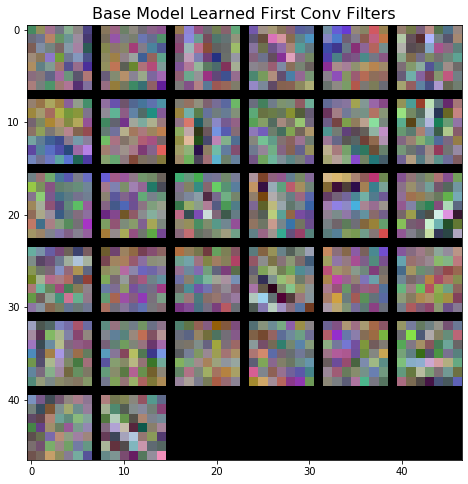

In [66]:
# Reset TF Graph
tf.reset_default_graph()
sess = tf.Session()

# Load BaseModel
model = BaseModel()
restore_model('csci-599_sample.ckpt')
viz_model('Base Model')

### Visualize Your Model [5pt]

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
conv2 layer: (?, 16, 16, 64)
conv3 layer: (?, 16, 16, 64)
conv4 layer: (?, 8, 8, 128)
conv5 layer: (?, 8, 8, 128)
conv6 layer: (?, 4, 4, 128)
flat layer: (?, 2048)
fc4 layer: (?, 512)
fc6 layer: (?, 10)
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv1/batch_normalization/gamma:0 from checkpoint. Name: conv1/batch_normalization/gamma
Loading conv1/batch_normalization/beta:0 from checkpoint. Name: conv1/batch_normalization/beta
Loading conv1/batch_normalization/moving_mean:0 from checkpoint. Name: conv1/batch_normalization/moving_mean
Loading conv1/batch_normalization/moving_variance:0 from checkpoint. Name: conv1/batch_normalization/moving_variance
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading conv2/batch_normalization/gamma:0 from checkpoint. Name: conv2/batch_normalization/gamma
Loa

(7, 7, 3, 32) (1, 1, 1, 32)


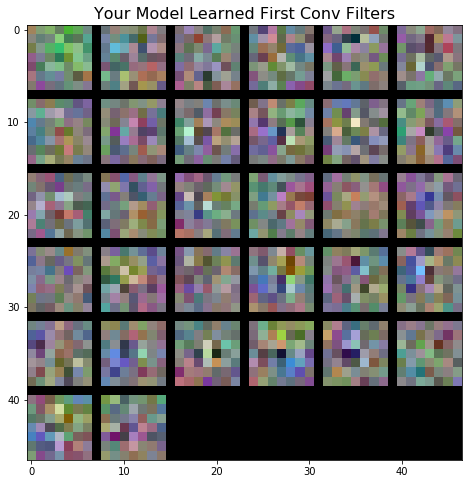

In [69]:
# Reset TF Graph
tf.reset_default_graph()
sess = tf.Session()

# Load BaseModel
model = YourModel()
restore_model('csci-599_mine.ckpt')
viz_model('Your Model')

### Inline Question: Do you see any difference in the visualizations of these two models? Explain why or why not. [2pt]
#### Ans: From the both images above, we could see that second layer is more capable of descriminating the input image features as it consists of more convolutional, fully connected and other  techniques modelled. where as the first image which is more blurred, it is due to a simple network.

## Visualizing Activations
Now that we have seen the learned filters, and observed that they have some patterns, we will go one step further to visualize the activation maps produced by different convolutional filters. You will see that as we go deeper through the layers of a network the activation maps gradually represent higher and higher levels of abstraction in the images.
Now, let's get some warm-up by running the following visualization code blocks for a simple model trained on MNIST dataset.

In [70]:
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

In [72]:
mnist = input_data.read_data_sets(os.path.join('data', 'MNIST_data'), one_hot=True)

Extracting data\MNIST_data\train-images-idx3-ubyte.gz
Extracting data\MNIST_data\train-labels-idx1-ubyte.gz
Extracting data\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting data\MNIST_data\t10k-labels-idx1-ubyte.gz


In [73]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784],name="x-in")
y = tf.placeholder(tf.float32, [None, 10],name="y-in")
keep_prob = tf.placeholder("float")

x_reshaped = tf.reshape(x,[-1,28,28,1])
x_tiled = tf.tile(x_reshaped, [1,1,1,3])
sconv_1 = slim.conv2d(x_tiled,5,[5,5], activation_fn=None)
srelu_1 = tf.nn.relu(sconv_1)
spool_1 = slim.max_pool2d(srelu_1,[2,2])

sconv_2 = slim.conv2d(spool_1,5,[5,5], activation_fn=None)
srelu_2 = tf.nn.relu(sconv_2)
spool_2 = slim.max_pool2d(srelu_2,[2,2])

sconv_3 = slim.conv2d(spool_2,20,[5,5], activation_fn=None)
srelu_3 = tf.nn.relu(srelu_2)
s_dropout3 = slim.dropout(srelu_3, keep_prob)
output = slim.fully_connected(slim.flatten(s_dropout3), 10, activation_fn=tf.nn.softmax)

cross_entropy = -tf.reduce_sum(y * tf.log(output))
correct_prediction = tf.equal(tf.argmax(output,1 ), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [74]:
batchSize = 50
dropout_p = 0.5

sess = tf.Session()
init = tf.global_variables_initializer() 
sess.run(init)

# Train the network
for i in range(2001):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x:batch[0], y:batch[1], keep_prob:dropout_p})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy, feed_dict={x:batch[0], y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

step 100, training accuracy 0.3
step 200, training accuracy 0.64
step 300, training accuracy 0.82
step 400, training accuracy 0.74
step 500, training accuracy 0.76
step 600, training accuracy 0.88
step 700, training accuracy 0.86
step 800, training accuracy 0.88
step 900, training accuracy 0.94
step 1000, training accuracy 0.82
step 1100, training accuracy 0.92
step 1200, training accuracy 0.94
step 1300, training accuracy 0.9
step 1400, training accuracy 0.86
step 1500, training accuracy 0.92
step 1600, training accuracy 0.96
step 1700, training accuracy 0.9
step 1800, training accuracy 0.96
step 1900, training accuracy 0.96
step 2000, training accuracy 0.94


In [75]:
testAccuracy = sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels, keep_prob:1.0})
print("test accuracy {}".format(testAccuracy))

test accuracy 0.9336000084877014


In [76]:
# function for visualizing the activations
def getActivations_mnist(layer, features):
    outs = sess.run(layer, feed_dict={x:np.reshape(features,[1,784],order='F'), keep_prob:1.0})
    outs = np.transpose(outs, [3, 1, 2, 0])
    fig = plt.figure(figsize=(4,4))   
    ax1 = plt.subplot(111)
    grid = viz_grid(outs)
    ax1.imshow(grid[...,0])
    ax1.set_title('{} Activations'.format(layer.name), fontsize=16)

The Image for activation visualizations:


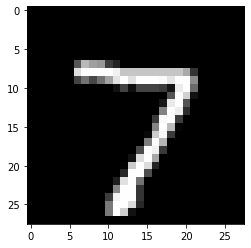

In [77]:
imageToUse = mnist.test.images[0]
imageToShow = np.expand_dims(np.reshape(imageToUse,[28,28]), axis=-1)
imageToShow = np.tile(imageToShow, (1,1,3))
plt.imshow(imageToShow, interpolation="nearest", cmap="gray")
print ("The Image for activation visualizations:")

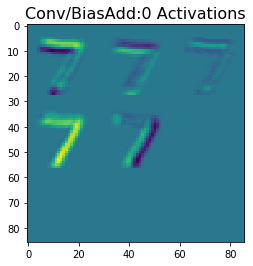

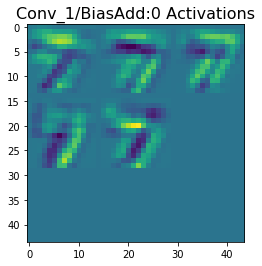

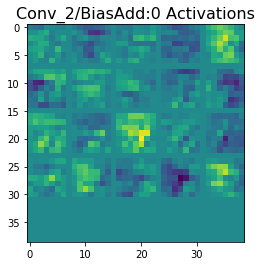

In [78]:
# Visualize the first 3 activation maps after convolution layers (without ReLU)
getActivations_mnist(sconv_1, imageToUse)
getActivations_mnist(sconv_2, imageToUse)
getActivations_mnist(sconv_3, imageToUse)

## Visualize the activations on your own model [4pt]
Now repeat the above procedure on your own model.

In [79]:
def getActivations_cifar10(layer, input_batch):
    #############################################################################
    # TODO: Fill out the following block for running the session                #
    # Hint: feed input to your model                                            #
    #############################################################################
    units = sess.run(layer, feed_dict={model.X : input_batch})
    units = np.transpose(units, [3, 1, 2, 0])
    
    # Define the figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)
    grid = viz_grid(units)
    ax1.imshow(grid[...,0])
    ax1.set_title('{} Activations'.format(layer.name), fontsize=16)

There are total 10000 images in test set
Image 998 in test set


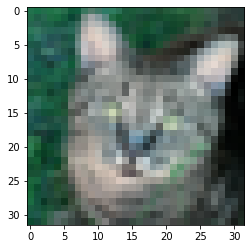

In [80]:
print ("There are total {} images in test set".format(len(data_test)))
#query_idx = 998
#############################################################################
# TODO: Try out some images from dataset by uncommenting the line below.    #
# Comment it back before submission!                                        #
#############################################################################
#query_idx = np.random.randint(0,999)

# Process the indicated issue
query_idx = min(max(query_idx, 0), 999)
cifar10ToUse = data_test[query_idx].astype(np.uint8)
cifar10ToUse= cifar10ToUse[...,::-1]
plt.imshow(cifar10ToUse)
print ("Image {} in test set".format(query_idx))

In [81]:
tf.reset_default_graph()
sess = tf.Session()

# Restore the model using parameters dict
model = BaseModel()
restore_model('csci-599_sample.ckpt')

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading fc3/dense/kernel:0 from checkpoint. Name: fc3/dense/kernel
Loading fc3/dense/bias:0 from checkpoint. Name: fc3/dense/bias
Loading fc4/dense/kernel:0 from checkpoint. Name: fc4/dense/kernel
Loading fc4/dense/bias:0 from checkpoint. Name: fc4/dense/bias
Loading Variable:0 from checkpoint. Name: Variable
Loading beta1_power:0 from checkpoint. Name: beta1_power
Loading beta2_power:0 from checkpoint. Name: beta2_power
Loading conv1/w/Adam:0 from checkpoint. Name: conv1/w/Adam
Loading conv1/w/Adam_1:0 from checkpoint. Name: conv1/w/Adam_1
Loading conv1/b/Adam:0 from checkpoint. Name: conv1/b/Adam
Loading conv1/b/Adam_1:0 

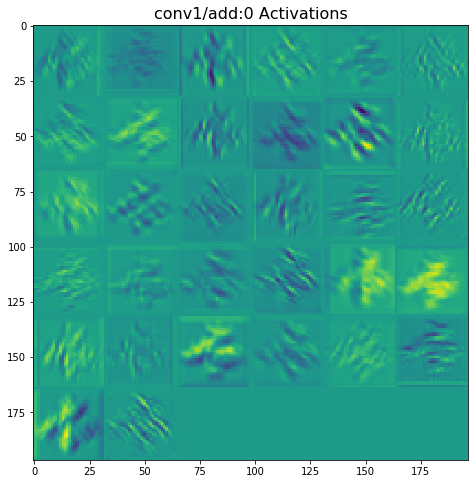

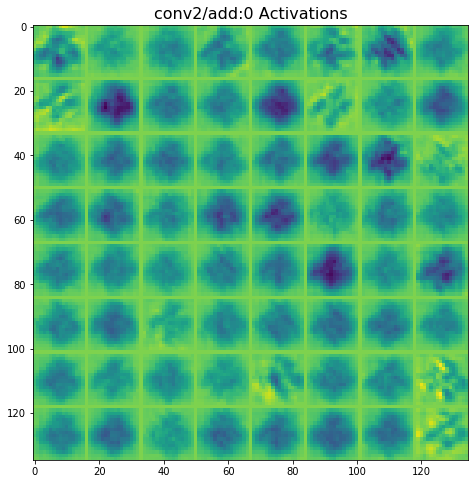

In [37]:
cifar10ToUse_with_batch = np.expand_dims(cifar10ToUse, axis=0)
####################################################################
# TODO: Visualize the activations of each conv layer in your model #
# by calling the visualization function you implemented.           #
####################################################################
getActivations_cifar10(model.conv1, cifar10ToUse_with_batch)
getActivations_cifar10(model.conv2, cifar10ToUse_with_batch)

### Inline Question: Describe your observation of how the activation changes across layers as we traverse through the network. [2pt]
#### Ans:  As we traverse through the network, from the above images we can say that the initial  layers focuses on capturing the edges, and curves of the image. As we traverse in depth into the network, the deeper layers help in identifing the class descriminative features like for ex. A dogs face, ears, nose which helps in identifying the class of the image

## Gradient-weighted Class Activation Mapping (Grad-CAM)
Grad-CAM is a technique for "visually interpreting" the predictions of a Convolutional Neural
Network (CNN)-based model. This technique essentially uses the gradients of any target concept
(a predicted class such as "cat"), flowing into the final convolutional layer to produce a coarse localization
map, attending regions in the image that are important for prediction of the concept.
Please read the original paper [Grad-CAM](https://arxiv.org/abs/1610.02391) for more details.

### Register the guided backpropagation ReLU (Run this function only once)

In [82]:
# Replace vanila relu to guided relu to get guided backpropagation.
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

KeyError: "Registering two gradient with name 'GuidedRelu'! (Previous registration was in register C:\\Users\\mohan\\Anaconda3\\envs\\tensorflow_cpu_env\\lib\\site-packages\\tensorflow\\python\\framework\\registry.py:66)"

### Some useful functions

In [83]:
import cv2

def imgread(path):
    print ("Image:", path.split("/")[-1])
    # Read in the image using python opencv
    img = cv2.imread(path)
    img = img / 255.0
    print ("Raw Image Shape: ", img.shape)
    
    # Center crop the image
    short_edge = min(img.shape[:2])
    W, H, C = img.shape
    to_crop = min(W, H)
    cent_w = int((img.shape[1] - short_edge) / 2)
    cent_h = int((img.shape[0] - short_edge) / 2)
    img_cropped = img[cent_h:cent_h+to_crop, cent_w:cent_w+to_crop]
    print ("Cropped Image Shape: ", img_cropped.shape)
    
    # Resize the cropped image to 224 by 224 for VGG16 network
    img_resized = cv2.resize(img_cropped, (224, 224), interpolation=cv2.INTER_LINEAR)
    print ("Resized Image Shape: ", img_resized.shape)
    return img_resized

def predicted_labels(score, synset_path):
    fi = open(synset_path, "rb")
    synset = []
    for line in fi:
        synset.append(line.rstrip().lstrip())
    
    # The predictions, reverse ordered
    pred = np.argsort(score)[::-1]

    # Top 1 and Top 5
    top1 = synset[pred[0]]
    print ("\nTop1, Label: {}, score: {}".format(top1, score[pred[0]]))
    top5 = [(synset[pred[i]], score[pred[i]]) for i in range(5)]
    for i in range(1,5):
        print ("Top{}, Label: {} score: {}".format(i+1, top5[i][0], top5[i][1]))
    return top1, top5

### Visualization Function

In [84]:
def visualize(image, output, grads, gb_grads):
    # Reverse the BGR channel to RGB
    gb_grads = gb_grads[...,::-1]

    # Initialzie CAM weights
    CAM = np.ones(output.shape[0 : 2], dtype = np.float32)  

    # Taking a weighted average
    cam_w = np.mean(grads, axis = (0, 1))
    for i, w in enumerate(cam_w):
        CAM += w * output[:, :, i]

    # Passing through ReLU
    CAM = np.maximum(CAM, 0)
    # scale CAM to [0,1]
    CAM /= np.max(CAM)
    # Resize the CAM to 224 by 224
    CAM = cv2.resize(CAM, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    # scale guided backprop gradients to [0,1]
    gb_grads -= np.min(gb_grads)
    gb_grads /= np.max(gb_grads)
    
    # scale the original to [0,1]
    img_toshow = image.astype(float)    
    img_toshow -= np.min(img_toshow)
    img_toshow /= img_toshow.max()

    # Render the CAM heatmap
    heatmap = cv2.applyColorMap(255 - np.uint8(CAM*255.0), cv2.COLORMAP_JET)

    # Grad-CAM
    CAM_gb = CAM.copy()
    CAM_gb = np.expand_dims(np.squeeze(CAM_gb), axis=-1)
    gd_gb = img_toshow[...,::-1] * np.tile(CAM_gb, (1,1,3))
    
    # Draw the results figures
    fig = plt.figure(figsize=(10,10))   
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    
    ax1.imshow(img_toshow[...,::-1])
    ax1.set_title('Input Image')
    ax2.imshow(heatmap)
    ax2.set_title('Grad-CAM')
    ax3.imshow(gb_grads)
    ax3.set_title('guided backpropagation')
    ax4.imshow(gd_gb)
    ax4.set_title('guided Grad-CAM')

    # Show the resulting image
    plt.show()

### Grad-CAM Main Implementation [6pt]

In this section, you will implement the visualization with GRAD-CAM over a pretrained VGG network.

Carefully read lib/tf_models/vgg.py for how to extract VGG layers.
You can extract layers or labels from VGG by accessing with the name.

e.g. vgg.conv2_2 extracts second convolution filter in conv2 family.

Image: images\corgi.jpg
Raw Image Shape:  (600, 900, 3)
Cropped Image Shape:  (600, 600, 3)
Resized Image Shape:  (224, 224, 3)
Image: images\cat_and_dog.jpg
Raw Image Shape:  (480, 640, 3)
Cropped Image Shape:  (480, 480, 3)
Resized Image Shape:  (224, 224, 3)
Image: images\cat_and_dog.jpg
Raw Image Shape:  (480, 640, 3)
Cropped Image Shape:  (480, 480, 3)
Resized Image Shape:  (224, 224, 3)
Model from C:\Users\mohan\Pictures\Assignment1\csci566-assignment1-master\lib\tf_models\vgg16.npy
Pretrained VGG16 successfully loaded!

Top1, Label: b'n02113186 Cardigan, Cardigan Welsh corgi', score: 0.3729470670223236
Top2, Label: b'n02113023 Pembroke, Pembroke Welsh corgi' score: 0.2394896149635315
Top3, Label: b'n02109961 Eskimo dog, husky' score: 0.2184201329946518
Top4, Label: b'n02110185 Siberian husky' score: 0.10455774515867233
Top5, Label: b'n02110063 malamute, malemute, Alaskan malamute' score: 0.03840108960866928


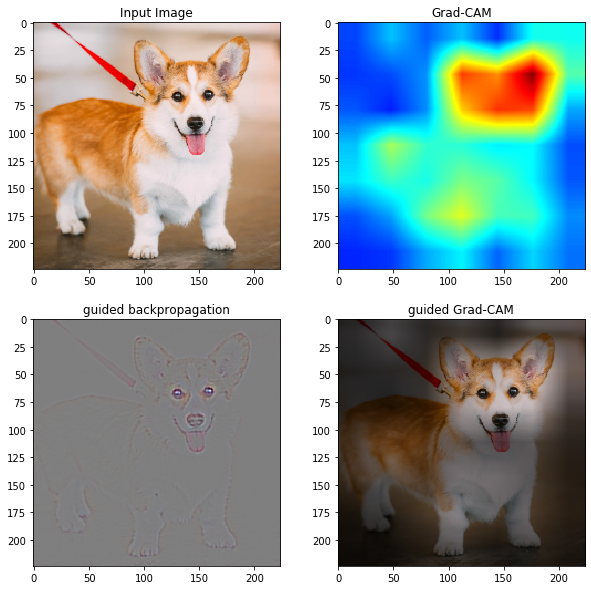


Top1, Label: b'n02110958 pug, pug-dog', score: 0.3903176486492157
Top2, Label: b'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier' score: 0.1110246330499649
Top3, Label: b'n02123159 tiger cat' score: 0.0852217897772789
Top4, Label: b'n02108422 bull mastiff' score: 0.05262855067849159
Top5, Label: b'n02123045 tabby, tabby cat' score: 0.04932306334376335


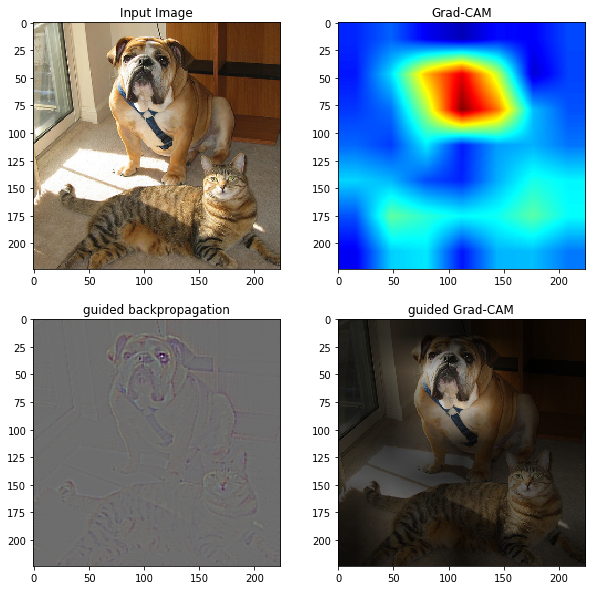


Top1, Label: b'n02110958 pug, pug-dog', score: 0.3903176486492157
Top2, Label: b'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier' score: 0.1110246330499649
Top3, Label: b'n02123159 tiger cat' score: 0.0852217897772789
Top4, Label: b'n02108422 bull mastiff' score: 0.05262855067849159
Top5, Label: b'n02123045 tabby, tabby cat' score: 0.04932306334376335


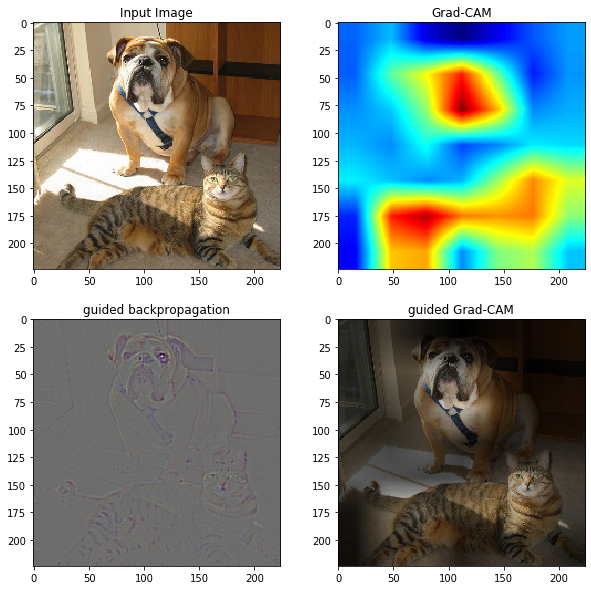

In [85]:
num_classes = 1000

# Read in the image
img1 = imgread(os.path.join("images", "corgi.jpg"))
img2 = imgread(os.path.join("images", "cat_and_dog.jpg"))
img3 = imgread(os.path.join("images", "cat_and_dog.jpg"))

# Expand one dimension to take on the batch dimension
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)
img3 = np.expand_dims(img3, axis=0)

# Define a all zero gradients of the shape 1000
zero_grads = np.array([0 for i in range(num_classes)])

# The indices of the classes are provided for you
class_num1 = 263  # Pembroke, Pembroke Welsh corgi
class_num2 = 254  # Pug, pug-dog
class_num3 = 282  # Tiger cat

# Define a one-hot gradient vector where the only activated gradient
# is of the corresponding indices from above 
one_hot_grad1 = zero_grads.copy()
one_hot_grad2 = zero_grads.copy()
one_hot_grad3 = zero_grads.copy()
one_hot_grad1[class_num1] = 1.0
one_hot_grad2[class_num2] = 1.0
one_hot_grad3[class_num3] = 1.0
one_hot_grad1 = np.expand_dims(one_hot_grad1, axis=0)
one_hot_grad2 = np.expand_dims(one_hot_grad2, axis=0)
one_hot_grad3 = np.expand_dims(one_hot_grad3, axis=0)

#############################################################################
# TODO: Construct a minibatch of data and labels of the                     #
# images using np.concatenate                                               #
#############################################################################
minibatch = np.concatenate([img1, img2, img3])
labels = np.concatenate([one_hot_grad1, one_hot_grad2, one_hot_grad3])


# Define the batch size
batch_size = 3

# Create tensorflow graph for evaluation
graph = tf.Graph()
with graph.as_default():
    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        # Define the VGG16 network and setup
        # Please take a look at the lib/tf_models/vgg16.py for more details
        # of the VGG16 network
        vgg = vgg16.Vgg16()
        vgg.load()
        vgg.setup()
        
        #############################################################################
        # TODO: Implement the signal and the loss                                   #
        #                                                                           #
        # Signal: Element-wise multiplication of final fully connected layer (fc8)  #
        # with the one-hot vector of labels.                                        #
        # Loss: Average of the Signal                                               #
        # Hint: Use tf.reduce_mean() function                                       #
        #############################################################################
        signal = tf.multiply(vgg.fc8,labels)
        loss = tf.reduce_mean(signal)


        #############################################################################
        # TODO: Compute the gradient of loss with respect to pool5 layer.           #
        # Hint: Use tf.gradients() and take the first element of output list        #
        #############################################################################
        pool5_grad = tf.gradients(loss, vgg.pool5)[0]
        

        #############################################################################
        # TODO: Compute the gradient of loss with respect to input layer.           #
        # This is the guided backpropagated gradient                                #
        #############################################################################
        inputs_grad = tf.gradients(loss,vgg.inputs)[0]
        eps = tf.constant(1e-5)

        #############################################################################
        # TODO: Normalize the gradients, and add a small number epsilon to it       #
        # Hint: Divide by norm                                                      #
        #############################################################################
        pool5_grad_normed = tf.divide(pool5_grad, tf.sqrt(tf.reduce_sum(tf.square(pool5_grad)))) + eps

        #############################################################################
        # TODO: I  nitializer for the tf variables                                    #
        #############################################################################
        init = tf.global_variables_initializer()
    
# Run tensorflow 
with tf.Session(graph=graph) as sess:    
    sess.run(init)
    #############################################################################
    # TODO: Run the session to get                                              #
    # (1) guided backpropagated gradients to the input                          #
    # (2) activation of pool5 (from vgg)                                        #
    # (3) normalized pool5 gradients                                            #
    # (4) output probabilities (from vgg)                                       #
    # Feed as input: batch of images and labels                                 #
    #############################################################################
    gb_grads, pool5_act, pool5_grads, prob =  sess.run([inputs_grad,vgg.pool5,pool5_grad_normed,vgg.prob],feed_dict={vgg.inputs:minibatch,vgg.labels:labels})
    
    # Visualize the Grad-CAM
    for i in range(batch_size):
        top1, top5 = predicted_labels(prob[i], os.path.join("lib", "synset.txt"))
        visualize(minibatch[i], pool5_act[i], pool5_grads[i], gb_grads[i])

### Inline Question: Describe your observation of the above results. What can you infer from these visualizations? [2pt]
#### Ans:

From the above results it is evident that the guided grad-CAM and grad-CAM visualizations helps a lot in the class predictions as they highlight the important regions in the input image. guided grad-CAM and grad-CAM performed better than the guided back propogation techniques. As we can see from the above, the guided back propogation images does not descriminate class target in the output image i.e., the cat and dog pictures are similar which is pretty difficult to descriminate where as the guided Grad-CAM and grad-CAM descriminalised the target dog from the cat(only the features of cat are highlighted)